In [2]:
library(tidyverse)
library(estimatr)
library(broom)

# STATISTICAL CONSTANTS
alpha <- 0.05
power_thresh <- 0.80

# STUDY DESIGN 
assignment_func <- NULL 
effect_sizes <- c(0.03,0.05,0.10,0.15)
sample_sizes <- seq(200, 10000, by = 500)
analysis_formula <- 'Y ~ X'
data_gen_func <- function(effect_size,sample_size) {
  tib <- tibble(
      X = sample(0:1,sample_size,replace=TRUE)
    ) %>%
      mutate(Y = effect_size*X+ (rbinom(sample_size,100,0.45)/100) + rnorm(sample_size, mean = 0, sd = 3))
  tib %>% return()
}


# SIMULATION CONSTANTS
num_sims_p_step <- 10

In [3]:
calc_power <- function(data_func,num_sims=500,form='Y~X',alpha=0.05) {
  sig_results <- c()
  for (i in 1:num_sims) {
    # Have to re-create the data EVERY TIME or it will just be the same data over and over
    mock_data <- data_func()
    # Run the analysis
    model <- lm_robust(as.formula(form), data = mock_data)
    # Get the results
    sig_results[i] <- tidy(model)$p.value[2] <= alpha
  }

  sig_results %>%
    mean() %>%
    return()
}

In [4]:
ex_data <- data_gen_func(.2,10000)
grouped <- group_by(ex_data,X)
summarize(grouped,
    mean_y=mean(Y))
calc_power(function() data_gen_func(.2,10000))

X,mean_y
<int>,<dbl>
0,0.4299262
1,0.6428130


[1] 0.912

In [5]:
params <- expand.grid(list(es=effect_sizes,ss=sample_sizes))

create_generator <- function(es,ss) function() data_gen_func(es,ss)
data_generators <- mapply(create_generator,
    params$es,
    params$ss)
    
power_res <- mapply(calc_power,
    data_generators,
    num_sims=num_sims_p_step,
    form=analysis_formula)
results <- params  %>% mutate(power = power_res)

In [6]:
results[results$es==0.15,]

,es,ss,power
,<dbl>,<dbl>,<dbl>
4,0.15,200,0.1
8,0.15,700,0.0
12,0.15,1200,0.1
16,0.15,1700,0.3
20,0.15,2200,0.3
24,0.15,2700,0.2
28,0.15,3200,0.4
32,0.15,3700,0.4
36,0.15,4200,0.3


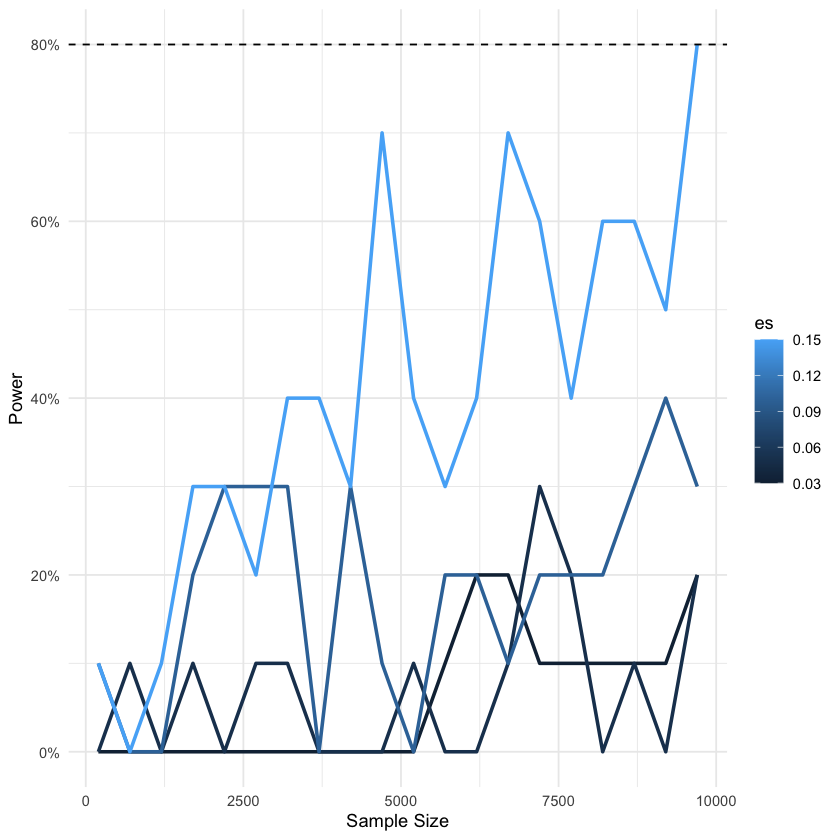

In [7]:
ggplot(results,
     aes(x = ss, y = power,group=es,color=es)) +
     geom_line(size=1) +
     # add a horizontal line at 90%
     geom_hline(aes(yintercept = power_thresh), linetype = 'dashed') + 
     # Prettify!
     theme_minimal() + 
     scale_y_continuous(labels = scales::percent) + 
     labs(x = 'Sample Size', y = 'Power')